In [6]:
from fastai.text import *
import html
import json

In [32]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

PATH=Path('data/bangla/output_folder_json/')

In [39]:
LM_PATH=Path('data/bangla/lm')
LM_PATH.mkdir(exist_ok=True)

In [35]:
LANG_FILENAMES = [str(f) for f in PATH.rglob("*/*")]
print(len(LANG_FILENAMES))
LANG_FILENAMES[0:5]

251


['data/bangla/output_folder_json/AA/wiki_05',
 'data/bangla/output_folder_json/AA/wiki_73',
 'data/bangla/output_folder_json/AA/wiki_14',
 'data/bangla/output_folder_json/AA/wiki_88',
 'data/bangla/output_folder_json/AA/wiki_08']

In [36]:
LANG_TEXT = []
for i in LANG_FILENAMES:
    for line in open(i):
        LANG_TEXT.append(json.loads(line))
        
LANG_TEXT = pd.DataFrame(LANG_TEXT)

In [38]:
LANG_TEXT.head(10)

,id,text,title,url
0,1528,"রবীন্দ্রনাথ ঠাকুর\n\nরবীন্দ্রনাথ ঠাকুর (৭ই মে,...",রবীন্দ্রনাথ ঠাকুর,https://bn.wikipedia.org/wiki?curid=1528
1,1529,কাজী নজরুল ইসলাম\n\nকাজী নজরুল ইসলাম (২৪ মে ১৮...,কাজী নজরুল ইসলাম,https://bn.wikipedia.org/wiki?curid=1529
2,1531,ডোনাল্ড কানুথ\n\nডনাল্ড কানুথ মার্কিন কম্পিউটা...,ডোনাল্ড কানুথ,https://bn.wikipedia.org/wiki?curid=1531
3,1532,"ক্লদ শান্নন\n\nক্লদ শ্যানন (এপ্রিল ৩০, ১৯১৬ - ...",ক্লদ শান্নন,https://bn.wikipedia.org/wiki?curid=1532
4,1533,বুলিয়ান বীজগণিত\n\nবুলিয়ান বীজগণিত () যা ১৮৫...,বুলিয়ান বীজগণিত,https://bn.wikipedia.org/wiki?curid=1533
5,1534,পশ্চিমবঙ্গের জেলা\n\nভারতীয় প্রজাতন্ত্রের পূর...,পশ্চিমবঙ্গের জেলা,https://bn.wikipedia.org/wiki?curid=1534
6,1537,প্রাক-ইতিহাস\n\nপ্রাক-ইতিহাস বা প্রাগৈতিহাসিক ...,প্রাক-ইতিহাস,https://bn.wikipedia.org/wiki?curid=1537
7,1541,মাইক্রোইলেকট্রনিক্স\n\nমাইক্রোইলেকট্রনিক্‌স ()...,মাইক্রোইলেকট্রনিক্স,https://bn.wikipedia.org/wiki?curid=1541
8,1542,ইন্টেল কর্পোরেশন\n\nইন্টেল কর্পোরেশন একটি আমের...,ইন্টেল কর্পোরেশন,https://bn.wikipedia.org/wiki?curid=1542
9,1543,সান মাইক্রোসিস্টেম্‌স\n\nসান মাইক্রোসিস্টেম্‌স...,সান মাইক্রোসিস্টেম্‌স,https://bn.wikipedia.org/wiki?curid=1543


In [40]:
LANG_TEXT.to_csv(f"{LM_PATH}/wiki_bangla_corpus.csv", index=False)

In [42]:
LANG_TEXT = pd.read_csv(f"{LM_PATH}/wiki_bangla_corpus.csv")

In [43]:
(LANG_TEXT.assign(labels = 0)
    .pipe(lambda x: x[['labels', 'text']])
    .to_csv(f"{LM_PATH}/wiki_bangla_corpus2.csv", header=None, index=False))


In [44]:
# Getting rid of the title name in the text field
def split_title_from_text(text):
    words = text.split("\n\n")
    if len(words) >= 2:
        return ''.join(words[1:])
    else:
        return ''.join(words)
    
LANG_TEXT['text'] = LANG_TEXT['text'].apply(lambda x: split_title_from_text(x))

In [45]:
LANG_TEXT.shape

(56794, 4)

In [46]:
LANG_TEXT['text'].apply(lambda x: len(x.split(" "))).sum()

13466495

In [48]:
len(set(''.join(LANG_TEXT['text'].values).split(" ")))


1195674

In [49]:
def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    #texts = texts.apply(fixup).values.astype(str)

    tok = Tokenizer().proc_all_mp(partition_by_cores(texts)) # splits the list into sublists for processing by each core
    # Lower and upper case is inside the tokenizer
    return tok, list(labels)

def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        #pdb.set_trace()
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [50]:
LANG_TEXT = pd.read_csv(f"{LM_PATH}/wiki_bangla_corpus2.csv", header=None)#, chunksize=5000)

In [51]:
trn_texts,val_texts = sklearn.model_selection.train_test_split(
    LANG_TEXT, test_size=0.1) # split the data into train and validation sets

In [52]:
np.random.seed(42)
trn_idx = np.random.permutation(len(trn_texts)) # generate a random ordering
val_idx = np.random.permutation(len(val_texts))

df_trn = trn_texts.iloc[trn_idx,:] # sort things randomly
df_val = val_texts.iloc[val_idx,:] # sort things randomly

df_trn.columns = ['labels', 'text']
df_val.columns = ['labels', 'text']

df_trn.to_csv(LM_PATH/'train.csv', header=False, index=False)
df_val.to_csv(LM_PATH/'test.csv', header=False, index=False) # saving the data in our new format to disk

In [53]:
chunksize = 10000
df_trn = pd.read_csv(LM_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(LM_PATH/'test.csv', header=None, chunksize=chunksize)


In [54]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
1
2
3
4
5
0


In [55]:
# create a tmp directory to store the upcoming numpy arrays
(LM_PATH/'tmp').mkdir(exist_ok=True)

# save the train and validation tokens in the tmp directories
np.save(LM_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(LM_PATH/'tmp'/'tok_val.npy', tok_val)


In [56]:
tok_trn = np.load(LM_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(LM_PATH/'tmp'/'tok_val.npy')

In [57]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(25)

[('।', 857797),
 (',', 418278),
 ('\n\n', 239672),
 ('\n', 215831),
 ('এবং', 176239),
 ('"', 163430),
 ('ও', 162658),
 ('হয়', 142035),
 (')', 124358),
 ('(', 118332),
 ('করে', 116737),
 ('এই', 100259),
 ('-', 99224),
 ('তিনি', 97601),
 ('করেন', 97482),
 ('.', 96143),
 ('একটি', 93408),
 ('থেকে', 83489),
 ('করা', 77533),
 ('সালে', 76631),
 ('এর', 75406),
 ('তার', 60658),
 ('1', 51707),
 ('জন্য', 51653),
 ('xbos', 51114)]

In [58]:
# Truncating our vocab to ignore the rare words
max_vocab = 60000
min_freq = 5

itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq] # getting rid of the rare words
itos.insert(0, '_pad_') # 
itos.insert(0, '_unk_') # itos is the list of all the strings in the vocab

In [59]:
# creating a index-key dictionary for our vocabulary
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

60002

In [60]:
# creating a index representation for our train and validation dataset
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [61]:
# saving our indexed representation of our dataset to disk
# we also save the index-word mapping to retrieve the complete text representation from these numpy arrays
np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl', 'wb'))

In [62]:
# Loading the indexed representation of our dataset from disk
# we also load the index-word mapping to to help us convert the indexes to word datasets, if need be.
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))

In [63]:
vs=len(itos)
vs,len(trn_lm)

(60002, 51114)

### Language model

In [68]:
em_sz,nh,nl = 400,1150,3

In [64]:
wd=1e-7
bptt=70
bs=52
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [65]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [66]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

In [69]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.unfreeze()

In [70]:
lr=1e-3
lrs = lr

In [71]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      5.613552   5.426314   0.259013  



[array([ 5.42631]), 0.25901323663053466]

In [72]:
learner.save('lm_bangla')

In [73]:
learner.load('lm_bangla')

In [74]:
learner.unfreeze()

In [75]:
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      5.262067   5.101219   0.266158  



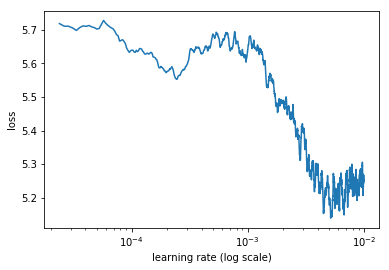

In [76]:
learner.sched.plot()

In [77]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=15)

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      5.148979   5.011724   0.279381  
    1      4.757724   4.648118   0.299924                     
    2      4.567575   4.489511   0.310747                     
    3      4.49539    4.404304   0.317561                     
    4      4.40383    4.353774   0.321817                     
    5      4.33027    4.323462   0.323819                     
    6      4.276771   4.296028   0.32617                      
    7      4.233598   4.272198   0.328526                     
    8      4.191952   4.256019   0.330026                     
    9      4.168982   4.239921   0.332133                     
    10     4.15503    4.223465   0.333736                     
    11     4.191968   4.206362   0.335214                     
    12     4.091851   4.206653   0.335193                     
    13     4.069589   4.19577    0.336439                     
    14     4.079597   4.18812    0.337388                     



[array([ 4.18812]), 0.33738842001048991]

In [78]:
learner.save('lm_bangla_15_epoch')

In [79]:
learner.save_encoder('lm_bangla_15_epoch_enc')

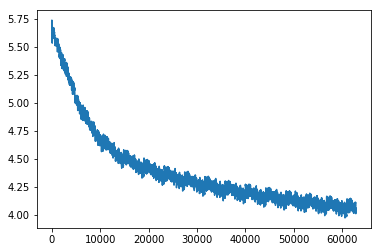

In [80]:
learner.sched.plot_loss()